In [126]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import warnings
import statsmodels.api as sm
from numpy import array

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from joblib import dump, load

# I - Création Fonctions 

## 1 - Sélection Données 

In [88]:
def Transformation(filename):
    """
    Transform any file from ClimateWatchData into the proper format
    
    filename: 'filename.csv'
    """
    df = pd.read_csv(filename,  header = 0)
    df.drop(['Data source', 'Unit'], axis =1, inplace=True)
    
    countries = df.Country.unique().tolist()
    countries.remove('European Union (27)')
    
    years_list = ['2019', '2018', '2017', '2016',
       '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
       '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998',
       '1997', '1996', '1995', '1994', '1993', '1992','1991', '1990']
    
    DF = pd.DataFrame(columns=['Country', 'Sector', 'Gas', 'year', 'cons'])

    for country in countries:
        temp_df = df[df['Country'] == country].reset_index() 
        for year in years_list :
            for row, value in enumerate(df[df['Country'] == country].reset_index()[year]):
                temp_df.loc[row, 'Country'] = country
                temp_df.loc[row, 'year'] = year
                temp_df.loc[row, 'cons'] = value
            DF = pd.concat([DF, temp_df], axis=0)           
            
    del_column = ['index', '2019', '2018', '2017', '2016',
       '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
       '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998',
       '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990']
    for column in del_column:
        del DF[column]  
        
    DF.set_index('year', inplace = True)
    DF.index = DF.index.astype('int')
    DF = DF.sort_index(ascending=True)
    return DF 

In [162]:
def Selector(df,Country,Sector,Gas):    
    """
    Return a df with datas from a specific country, sector and gas
    
    """
    selection = df[(df['Sector'] == Sector) 
                                 & (df['Gas'] == Gas) 
                                 & (df['Country'] == Country)]    
    
    if Sector == 'Industrial Processes':
        selection.dropna(inplace = True)
    
    selection= selection.drop(['Country','Sector','Gas'], axis = 1) 
    
    
    plt.figure(figsize = (10,4))
    plt.plot(selection)
    plt.ylabel("Emissions in MtCO₂e")
    plt.title('Evolution of '+Gas+' emissions for '+Sector+' sector in '+Country)

    return selection

## 2 - Machine Learning

In [90]:
def calculate_scores(y_true,y_pred):
    mae = round(mean_absolute_error(y_true,y_pred), 3)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)
    mape = round(mean_absolute_percentage_error(y_true, y_pred), 3)
    r2 = round(r2_score(y_true,y_pred), 3)
    
    #print("MAE:", mae)
   # print("RMSE:", rmse)
    #print("MAPE:", mape)
   # print("r2:", r2)
   
    return mae, rmse, mape, r2

In [91]:
def Lin_reg(df, show_plot = True):
    
    train, test = train_test_split(df, test_size = 0.2, shuffle = False)

    X_train_lr = pd.DataFrame(train.index)
    y_train_lr = train
    X_test_lr = pd.DataFrame(test.index)
    y_test_lr = test

    lr = LinearRegression()

    lr.fit(X_train_lr,y_train_lr)
    y_pred_lr = lr.predict(X_test_lr)
    
    lr = LinearRegression()

    lr.fit(pd.DataFrame(df.index),df)
    forecasts_lr = lr.predict(pd.DataFrame(range(2020, 2031)))
    
    #calculate_scores(y_test_lr, y_pred_lr)
    mae_scores['Naive linear regression'], rmse, mape, r2 =  calculate_scores(y_test_lr, y_pred_lr)
    level_2030['Naive linear regression']  = np.round(forecasts_lr[-1], 1)
    delta['Naive linear regression']  = np.round((forecasts_lr[-1] - df.iloc[0,0])*100/df.iloc[0, 0], 1)

    if show_plot:
                     
        print("MAE:",  mae_scores['Naive linear regression'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)
    
        plt.figure(figsize = (10,4))
        plt.plot(df, label ='Reality')
        plt.plot(X_test_lr, y_pred_lr, label ='Predictions')
        plt.plot(range(2020,2031), forecasts_lr, label = 'Forecasts')
        plt.title('Predictions and forecasts with "naive" Linear Regression')
        plt.ylabel("Emissions in MtCO₂e")
        plt.legend();

    return forecasts_lr

## 3 - ARIMA

In [160]:
    
def ARIMA(df, show_plot = True):
    # saving df index
    indexes = df.index

    # Finding best parameters for ARIMA model
   
    df.index= pd.to_datetime(df.index, format='%Y')
    train, test = train_test_split(df, test_size = 0.2, shuffle = False)
    
    if len(train)>22:
        p_values = range(0,6 )
        d_values = range(0, 3)
        q_values = range(0, 6)
    else:
        p_values = range(0, 5 )
        d_values = range(0, 3)
        q_values = range(0, 5)       

    best_score = float("inf")
    best_params = (0,0,0)
    arima_pred = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                warnings.filterwarnings("ignore")
                model = sm.tsa.arima.ARIMA(train, order=order).fit()
                predictions = model.predict(start=len(train), end=len(train) + len(test)-1)
                error = mean_absolute_error(test, predictions)
                if error < best_score:
                    best_score = error
                    best_params = order
                    arima_pred = predictions
    
    # Using best parameters for ARIMA model
    
    #arima = sm.tsa.arima.ARIMA(train, order=best_params)
    #arima_fitted = arima.fit()
       
    #arima_pred = arima_fitted.get_forecast(steps =6).summary_frame() 
      
    
    # training on full dataset then making forecasts 

    arima = sm.tsa.arima.ARIMA(df, order=best_params)
    arima_fitted = arima.fit()

    arima_forecasts = arima_fitted.get_forecast(steps =11).summary_frame() 
    
    
    #saving results
    mae_scores['ARIMA'], rmse, mape, r2  =  calculate_scores(test,arima_pred)
    level_2030['ARIMA']  = np.round(arima_forecasts['mean'][-1],1)
    delta['ARIMA']  = np.round((arima_forecasts['mean'][-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)
    
    # Plot prediction and forecasts

    if show_plot:
        
        print('Best ARIMA%s MAE=%.3f' % (best_params, best_score)),arima_fitted.summary()
        print("MAE:",  mae_scores['ARIMA'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)

        fig, ax = plt.subplots(figsize = (10,4))

        plt.plot(df, label = 'real emissions')

        arima_pred.plot(ax = ax, style = 'k--', label = 'predictions') 

        arima_forecasts['mean'].plot(ax = ax, style = '--', color = 'red', label = 'forecasts') 

        #ax.fill_between(arima_pred.index, arima_pred['mean_ci_lower'], arima_pred['mean_ci_upper'], color='k', alpha=0.1)

        ax.fill_between(arima_forecasts.index, arima_forecasts['mean_ci_lower'], arima_forecasts['mean_ci_upper'], color='k', alpha=0.1)
        plt.title('Predictions and forecasts with ARIMA')
        plt.ylabel("Emissions in MtCO₂e")
        plt.legend(loc = 'upper left');

    # restore df index
    df.index= indexes
    
    return arima_forecasts['mean']

## Linear +

In [93]:
def window_dataset(series, window):

    L = len(series)
    X = series.values
    df = pd.DataFrame(data = series.values)
    
    for i in range(window):
        y = []
        for i in range(L - 1):
            y.append(X[i+ 1])
        df = pd.concat([df,pd.DataFrame(y)], axis=1)
        L = L-1
        X = y  
    df.columns = ['X'+str(i) for i in range(window+1)]
    df.index = range(1990 + window, 1990 + window + df.shape[0])

    return df.iloc[:-window]

In [94]:
def LinearR(df, window = 1, show_plot = True):
    
    #Dataset 
    new_df = window_dataset(df,window)
    target = new_df['X'+str(window)]
    data = new_df.drop('X'+str(window), axis = 1)
    
    #training
    X_train, X_test, y_train, y_test= train_test_split(data, target,test_size = 0.2, shuffle = False) 
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    #predictions
    y_pred_lr = lr.predict(X_test)
    
    #training on full dataset
    lr = LinearRegression()
    lr.fit(data, target)
    
    #forecasts
    feat = new_df.iloc[-1:,1:window+1].values

    future = []
    
    for i in range(11):
        pred = lr.predict(feat.reshape(1, -1))
        future.append(pred)
        feat = np.delete(feat,[0])
        feat = np.append(feat,pred)
 
    forecasts_lr = future
    
    mae_scores['Linear regression'], rmse, mape, r2  =  calculate_scores(y_test, y_pred_lr)
    level_2030['Linear regression']  = np.round(forecasts_lr[-1], 1)
    delta['Linear regression']  = np.round((forecasts_lr[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)
    
    # linear graph
    
    if show_plot:

        print('Rolling timesteps: ', window, '\n')
        print("MAE:",  mae_scores['Linear regression'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)
    
        plt.figure(figsize = (10,4))
        plt.plot(df.index, df, label ='reality')
        plt.plot(X_test.index, y_pred_lr, label ='prediction')
        plt.plot(range(2020,2031), forecasts_lr, label = 'forecasts')
        plt.ylabel("Emissions in MtCO₂e")
        plt.title('Predictions and forecasts with Linear Regression')
        plt.legend();
    
    return forecasts_lr

## 4 - SVM

In [95]:
def SVM(df, window=1, show_plot = True):

    #Dataset 
    new_df = window_dataset(df,window)
    target = new_df['X'+str(window)]
    data = new_df.drop('X'+str(window), axis = 1)
    
    #training
    X_train, X_test, y_train, y_test= train_test_split(data, target,test_size = 0.2, shuffle = False)
    
    params = {'C': np.arange(1,11,10),
          'kernel': ['linear', 'rbf'],
          'epsilon': np.arange(0.1, 0.5, 0.1)}
    
    model = SVR()
    cv = GridSearchCV(model, param_grid = params )
    cv.fit(X_train, y_train)
    
    #predictions
    y_pred_svm = cv.predict(X_test)
    
    #training on full dataset
    svm = cv.best_estimator_
    svm.fit(data,target)
    
    #forecasts
    feat = new_df.iloc[-1:,1:window+1].values

    future = []
    
    for i in range(11):
        pred = svm.predict(feat.reshape(1, -1))
        future.append(pred)
        feat = np.delete(feat,[0])
        feat = np.append(feat,pred)

    forecasts_svm = future
    
    #saving results
    mae_scores['SVM'], rmse, mape, r2  =  calculate_scores(y_test, y_pred_svm)
    level_2030['SVM']  = np.round(forecasts_svm[-1],1)
    delta['SVM']  = np.round((forecasts_svm[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)
 
    # svm graph
    
    if show_plot:    
        print('Rolling timesteps: ', window, '\n')
        print("MAE:",  mae_scores['SVM'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)

        plt.figure(figsize = (10,4))
        plt.plot(df.index, df, label ='reality')
        plt.plot(X_test.index, y_pred_svm, label ='prediction')
        plt.plot(range(2020,2031), forecasts_svm, label = 'forecasts')
        plt.ylabel("Emissions in MtCO₂e")
        plt.title('Predictions and forecasts with SVM')
        plt.legend();
    
    return forecasts_svm

# Deep learning

In [96]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

## Vanilla LSTM

In [150]:
def Vanilla_LSTM(df,n_steps =3, show_plot = True):
    
    X_train, X_test = train_test_split(df, test_size = 0.2, shuffle = False)
    
    X, y = split_sequence(X_train.values, n_steps)

    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define and train model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    model.fit(X, y, epochs=200, verbose=0)
    
    #predictions
    n_years = df.shape[0] - X.shape[0] + X_test.shape[0]
    Xinput = X[-1]

    for i in range(n_years):
        x_input = Xinput[-n_steps:]
        x_input = x_input.reshape((1, n_steps, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, y))
    
    predictions = Xinput[-X_test.shape[0]:]  
    
    #reset model and train on full dataset
    model.reset_states()

    X, y = split_sequence(df.values, n_steps)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    model.fit(X, y, epochs=200, verbose=0)
    
    #forecasts
    Xinput = X[-1]
    n_years = df.shape[0] - X.shape[0] + 11
    for i in range(n_years):
        x_input = Xinput[-n_steps:]
        x_input = x_input.reshape((1, n_steps, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, y))
    
    forecasts = Xinput[-11:] 
    
    #saving results
    mae_scores['Vanilla LSTM'], rmse, mape, r2  =  calculate_scores(X_test, predictions)
    level_2030['Vanilla LSTM']  = np.round(forecasts[-1])
    delta['Vanilla LSTM']  = np.round((forecasts[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)    
    
    #graph
    if show_plot:    
        print('Rolling timesteps: ', n_steps, '\n') 
        print("MAE:",  mae_scores['Vanilla LSTM'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)   
    
        plt.figure(figsize = (10,4))

        plt.plot(df.index,df, label ='Reality')
        plt.plot(X_test.index, predictions ,label= 'Prediction')
        plt.plot(list(range(2020, 2031)), forecasts, label = 'Forecasts')

        plt.xlabel('Years')
        plt.ylabel('Emissions in MtCO2e')
        plt.title('Predictions and forecasts with Vanilla LSTM')
        plt.legend();

    return forecasts


## Stacked LSTM

In [152]:
def Stacked_LSTM(df, n_steps=4, show_plot=True):
   
    X_train, X_test = train_test_split(df, test_size = 0.2, shuffle = False)
    
    X, y = split_sequence(X_train.values, n_steps)

    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    # fit model
    model.fit(X, y, epochs=200, verbose=0)
    
    #predictions
    n_years = df.shape[0] - X.shape[0] + X_test.shape[0]
    Xinput = X[-1]

    for i in range(n_years):
        x_input = Xinput[-n_steps:]
        x_input = x_input.reshape((1, n_steps, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, y))
    
    predictions = Xinput[-X_test.shape[0]:]  
    
    #reset model and train on full dataset
    model.reset_states()

    X, y = split_sequence(df.values, n_steps)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    model.fit(X, y, epochs=200, verbose=0)
    
    #forecasts
    Xinput = X[-1]
    n_years = df.shape[0] - X.shape[0] + 11
    for i in range(n_years):
        x_input = Xinput[-n_steps:]
        x_input = x_input.reshape((1, n_steps, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, y))
    
    forecasts = Xinput[-11:] 
    
    #saving results   
    mae_scores['Stacked LSTM'], rmse, mape, r2  = calculate_scores(X_test, predictions)
    level_2030['Stacked LSTM']  = np.round(forecasts[-1],1)
    delta['Stacked LSTM']  = np.round((forecasts[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)
    
    #graph
    if show_plot:
        print('Rolling timesteps: ', n_steps, '\n')
        print("MAE:",  mae_scores['Stacked LSTM'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)      
    
        plt.figure(figsize = (10,4))

        plt.plot(df.index,df, label ='Reality')
        plt.plot(X_test.index, predictions ,label= 'Prediction')
        plt.plot(range(2020, 2031), forecasts, label = 'Forecasts')

        plt.xlabel('Years')
        plt.ylabel('Emissions in MtCO2e')
        plt.title('Predictions and forecasts with Stacked LSTM')
        plt.legend();
  
    return forecasts

## Bidirectionnal LSTM

In [153]:
def Bidirectional_LSTM(df, n_steps=4, show_plot = True):
 
    X_train, X_test = train_test_split(df, test_size = 0.2, shuffle = False)
    
    X, y = split_sequence(X_train.values, n_steps)

    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))   
    
    # define model
    model= Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)
    
    #predictions
    n_years = df.shape[0] - X.shape[0] + X_test.shape[0]
    Xinput = X[-1]

    for i in range(n_years):
        x_input = Xinput[-n_steps:]
        x_input = x_input.reshape((1, n_steps, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, y))
    
    predictions = Xinput[-X_test.shape[0]:]  
    
    #reset model and train on full dataset
    model.reset_states()

    X, y = split_sequence(df.values, n_steps)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    model.fit(X, y, epochs=200, verbose=0)
    
    #forecasts
    Xinput = X[-1]
    n_years = df.shape[0] - X.shape[0] + 11
    for i in range(n_years):
        x_input = Xinput[-n_steps:]
        x_input = x_input.reshape((1, n_steps, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, y))
    
    forecasts = Xinput[-11:] 
    
    #saving results   
    mae_scores['Bidirectional LSTM'], rmse, mape, r2  = calculate_scores(X_test, predictions)
    level_2030['Bidirectional LSTM']  = np.round(forecasts[-1],1)
    delta['Bidirectional LSTM']  = np.round((forecasts[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)    
    
    #graph
    if show_plot:
        print('Rolling timesteps: ', n_steps, '\n')
        print("MAE:",  mae_scores['Bidirectional LSTM'])
        print("RMSE:", rmse)
        print("MAPE:", mape)
        print("r2:", r2)       
   
        plt.figure(figsize = (10,4))

        plt.plot(df.index,df, label ='Reality')
        plt.plot(X_test.index, predictions ,label= 'Prediction')
        plt.plot(range(2020, 2031), forecasts, label = 'Forecasts')

        plt.xlabel('Years')
        plt.ylabel('Emissions in MtCO2e')
        plt.title('Predictions and forecasts with Bidirectional LSTM')
        plt.legend();
    
    return forecasts

## CNN LSTM

In [154]:
def CNN_LSTM(df, n_steps=4, n_seq=2 , n_steps_seq=2, show_plot = True) :

    if not ((n_steps >= n_seq) and (n_seq >= n_steps_seq)):
        print('Paramètres incompatibles : veuillez choisir n_steps >= n_seq >= n_steps_seq')
        
    else :         
        X_train, X_test = train_test_split(df, test_size = 0.2, shuffle = False)

        # split into samples
        X, y = split_sequence(X_train.values, n_steps)

       # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], n_seq, n_steps_seq, n_features))

        # define model

        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps_seq, n_features)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_absolute_error')
        # fit model

        model.fit(X, y, epochs=200, verbose=0)

        #predictions
        n_years = df.shape[0] - X.shape[0] + X_test.shape[0]
        Xinput = X[-1].reshape(-1,1)

        for i in range(n_years):
            x_input = Xinput[-n_steps:]
            x_input = x_input.reshape((1, n_seq, n_steps_seq, n_features))
            y = model.predict(x_input, verbose=0)
            Xinput = np.concatenate((Xinput, y))

        predictions = Xinput[-X_test.shape[0]:]  

        #reset model and train on full dataset
        model.reset_states()

        X, y = split_sequence(df.values, n_steps)
        n_features = 1
        X = X.reshape((X.shape[0], n_seq, n_steps_seq, n_features))

        model.fit(X, y, epochs=20, verbose=0)

        #forecasts
        Xinput = X[-1].reshape(-1,1)
        n_years = df.shape[0] - X.shape[0] + 11
        for i in range(n_years):
            x_input = Xinput[-n_steps:]
            x_input = x_input.reshape((1, n_seq, n_steps_seq, n_features))
            y = model.predict(x_input, verbose=0)
            Xinput = np.concatenate((Xinput, y))

        forecasts = Xinput[-11:] 

        #saving results         
        mae_scores['CNN LSTM'], rmse, mape, r2 =  calculate_scores(X_test, predictions)
        level_2030['CNN LSTM']  = np.round(forecasts[-1], 1)    
        delta['CNN LSTM']  = np.round((forecasts[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)

        #graph
        if show_plot:
            print('Rolling timesteps: ', n_steps)
            print('Subsequence size: ', n_seq)
            print('Subsequence timesteps: ', n_steps_seq, '\n')
            print("MAE:",  mae_scores['CNN LSTM'])
            print("RMSE:", rmse)
            print("MAPE:", mape)
            print("r2:", r2)              

            plt.figure(figsize = (10,4))

            plt.plot(df.index,df, label ='Reality')
            plt.plot(X_test.index, predictions ,label= 'Prediction')
            plt.plot(range(2020, 2031), forecasts, label = 'Forecasts')

            plt.xlabel('Years')
            plt.ylabel('Emissions in MtCO2e')
            plt.title('Predictions and forecasts with CNN LSTM')
            plt.legend();
        
    return forecasts

## Conv LSTM

In [155]:
def Conv_LSTM(df, n_steps=4, n_seq=2 , n_steps_seq=2, show_plot = True) :

    if not ((n_steps >= n_seq) and (n_seq >= n_steps_seq)):
        print('Paramètres incompatibles : veuillez choisir n_steps >= n_seq >= n_steps_seq')
        
    else :  
            
        X_train, X_test = train_test_split(df, test_size = 0.2, shuffle = False)

        # split into samples
        X, y = split_sequence(X_train.values, n_steps)

        # reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
        n_features = 1
        X = X.reshape((X.shape[0], n_seq, 1, n_steps_seq, n_features))

        # define model
        model = Sequential()
        model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_seq, n_features)))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # fit model
        model.fit(X, y, epochs=200, verbose=0) 

        #predictions
        n_years = df.shape[0] - X.shape[0] + X_test.shape[0]
        Xinput = X[-1].reshape(-1,1)

        for i in range(n_years):
            x_input = Xinput[-n_steps:]
            x_input = x_input.reshape((1, n_seq, 1, n_steps_seq, n_features))
            y = model.predict(x_input, verbose=0)
            Xinput = np.concatenate((Xinput, y))

        predictions = Xinput[-X_test.shape[0]:]  

        #reset model and train on full dataset
        model.reset_states()

        X, y = split_sequence(df.values, n_steps)
        n_features = 1
        X = X.reshape((X.shape[0], n_seq, 1, n_steps_seq, n_features))

        model.fit(X, y, epochs=200, verbose=0)

        #forecasts
        Xinput = X[-1].reshape(-1,1)
        n_years = df.shape[0] - X.shape[0] + 11
        for i in range(n_years):
            x_input = Xinput[-n_steps:]
            x_input = x_input.reshape((1, n_seq, 1, n_steps_seq, n_features))
            y = model.predict(x_input, verbose=0)
            Xinput = np.concatenate((Xinput, y))

        forecasts = Xinput[-11:] 

        #saving results   
        mae_scores['Conv LSTM'], rmse, mape, r2  =  calculate_scores(X_test, predictions)
        level_2030['Conv LSTM']  = np.round(forecasts[-1], 1)   
        delta['Conv LSTM']  = np.round((forecasts[-1] - df.iloc[0,0])*100/df.iloc[0,0], 1)        
        
        #graph
        if show_plot:
            print('Rolling timesteps: ', n_steps)
            print('Subsequence size: ', n_seq)
            print('Subsequence timesteps: ', n_steps_seq, '\n')
            print("MAE:",  mae_scores['Conv LSTM'])
            print("RMSE:", rmse)
            print("MAPE:", mape)
            print("r2:", r2)               

            plt.figure(figsize = (10,4))

            plt.plot(df.index,df, label ='Reality')
            plt.plot(X_test.index, predictions ,label= 'Prediction')
            plt.plot(range(2020, 2031), forecasts, label = 'Forecasts')

            plt.xlabel('Years')
            plt.ylabel('Emissions in MtCO2e')
            plt.title('Predictions and forecasts with Conv LSTM')
            plt.legend();
        
    return forecasts

# II - Tests


In [102]:
df = Transformation('historical_emissions.csv')

In [103]:
df.Country.unique()

array(['Sweden', 'Luxembourg', 'Austria', 'Belgium', 'Hungary',
       'Portugal', 'Latvia', 'Cyprus', 'Spain', 'Lithuania', 'Bulgaria',
       'Estonia', 'Netherlands', 'Germany', 'Malta', 'Czech Republic',
       'Denmark', 'Slovakia', 'Poland', 'Greece', 'Ireland', 'France',
       'Slovenia', 'Croatia', 'Finland', 'Italy', 'Romania'], dtype=object)

In [104]:
df.Sector.unique()

array(['Waste', 'Bunker Fuels', 'Building', 'Agriculture',
       'Transportation', 'Total including LUCF', 'Total excluding LUCF',
       'Other Fuel Combustion', 'Electricity/Heat',
       'Manufacturing/Construction', 'Land-Use Change and Forestry',
       'Industrial Processes', 'Fugitive Emissions', 'Energy'],
      dtype=object)

In [105]:
df.Gas.unique()

array(['N2O', 'CO2', 'All GHG', 'CH4', 'F-Gas'], dtype=object)

## France

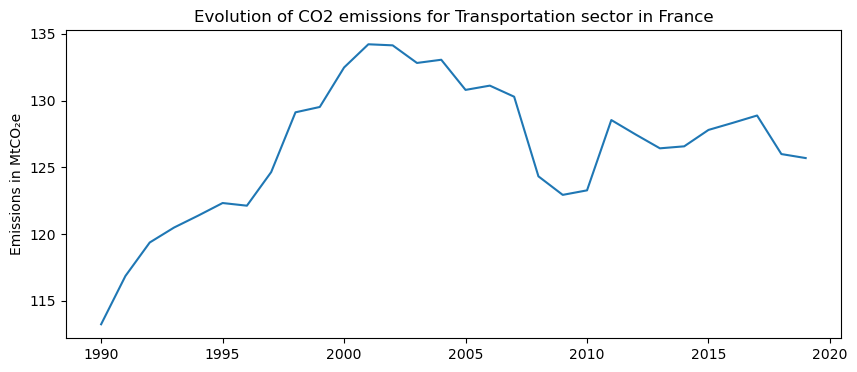

In [163]:
new_df = Selector(df=df,Country='France',Sector= 'Transportation', Gas = 'CO2')
plt.savefig("series.png")

In [107]:
#initializing tables
mae_scores = {}
level_2030 = {}
delta = {}

MAE: 5.441
RMSE: 5.677
MAPE: 0.043
r2: -21.482


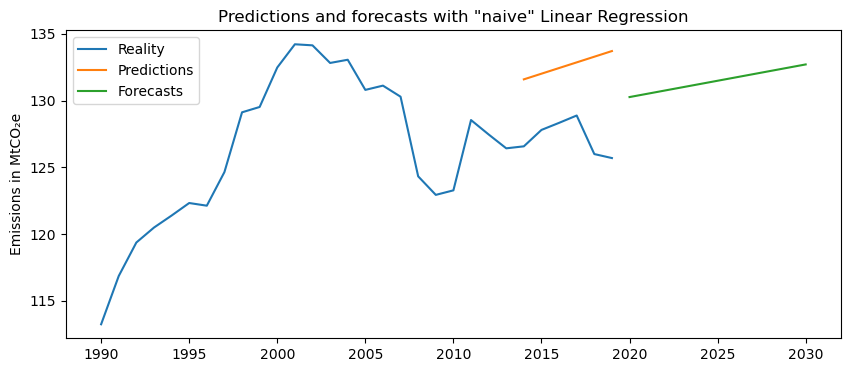

In [128]:
Lin_reg(new_df);
plt.savefig("naive_lin.png")

Best ARIMA(4, 0, 5) MAE=0.797
MAE: 0.797
RMSE: 0.921
MAPE: 0.006
r2: 0.408


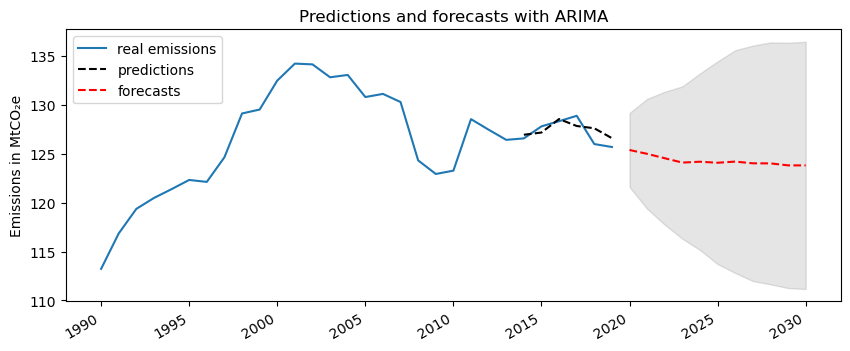

In [161]:
ARIMA(new_df);
plt.savefig("arima.png")

In [110]:
new_df.index

Int64Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
            2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64', name='year')

Rolling timesteps:  1 

MAE: 0.934
RMSE: 1.239
MAPE: 0.007
r2: -0.072


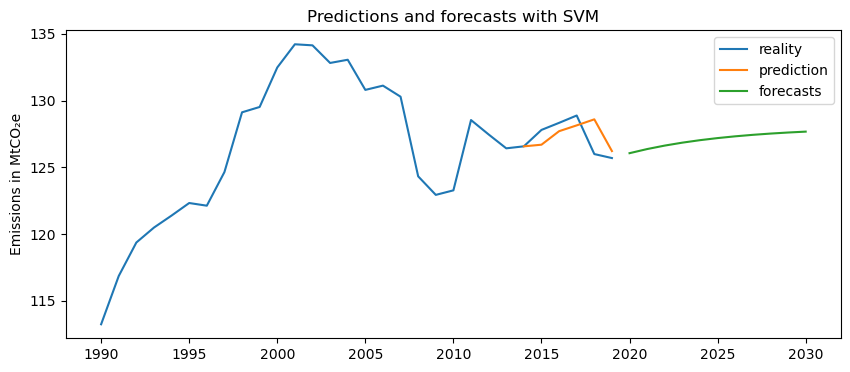

In [130]:
SVM(new_df, 1);
plt.savefig("svm.png")

Rolling timesteps:  1 

MAE: 0.939
RMSE: 1.317
MAPE: 0.007
r2: -0.21


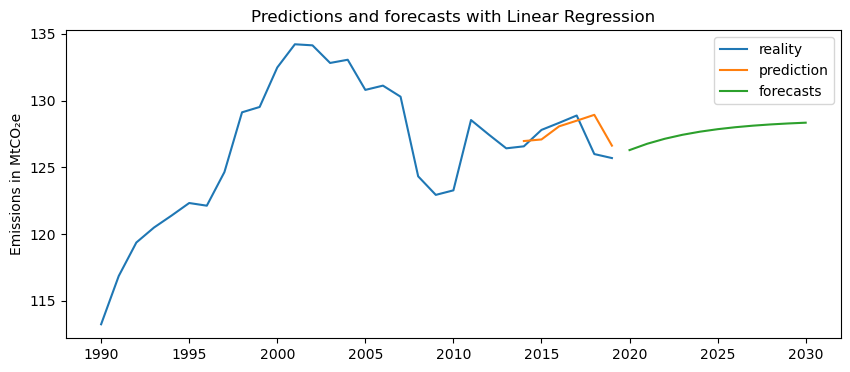

In [149]:
LinearR(new_df, 1);
plt.savefig("linreg.png")

Rolling timesteps:  3 

MAE: 1.202
RMSE: 1.461
MAPE: 0.01
r2: -0.489


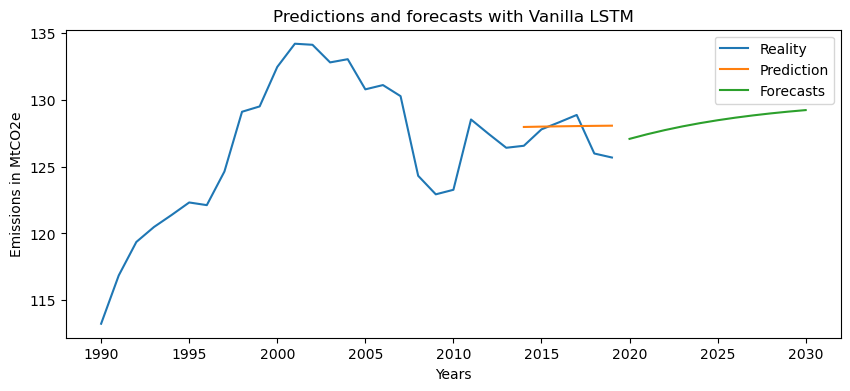

In [151]:
Vanilla_LSTM(new_df, 3);
plt.savefig("vanilla_lstm.png")

Rolling timesteps:  3 

MAE: 1.174
RMSE: 1.413
MAPE: 0.009
r2: -0.394


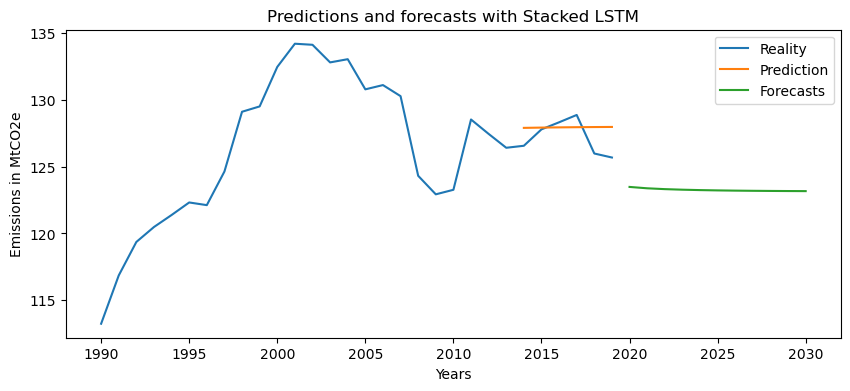

In [156]:
Stacked_LSTM(new_df, 3);
plt.savefig("stacked_lstm.png")

Rolling timesteps:  3 

MAE: 7.208
RMSE: 7.328
MAPE: 0.057
r2: -36.471


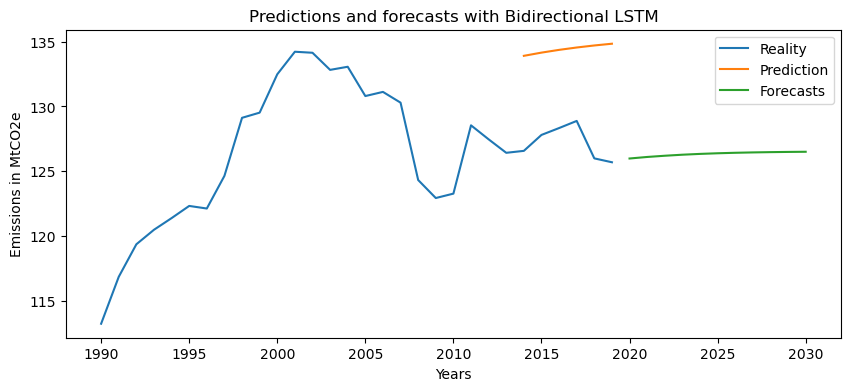

In [159]:
Bidirectional_LSTM(new_df, 3);
plt.savefig("bidirectional.png")

Rolling timesteps:  4
Subsequence size:  2
Subsequence timesteps:  2 

MAE: 6.08
RMSE: 6.282
MAPE: 0.048
r2: -26.529


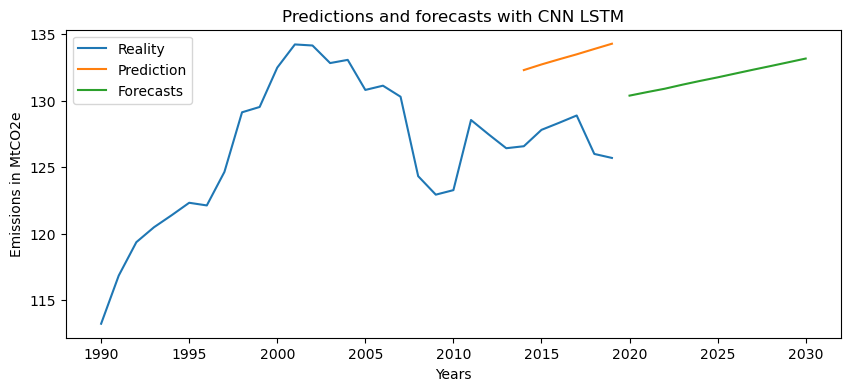

In [157]:
CNN_LSTM(new_df, 4, 2, 2);
plt.savefig("cnn_lstm.png")

Rolling timesteps:  4
Subsequence size:  2
Subsequence timesteps:  2 

MAE: 3.635
RMSE: 3.892
MAPE: 0.029
r2: -9.57


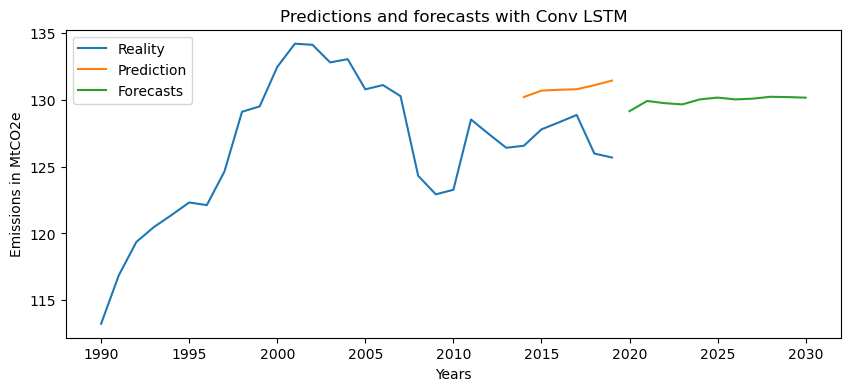

In [158]:
Conv_LSTM(new_df, 4, 2, 2);
plt.savefig("conv_lstm.png")

In [118]:
mae_scores['FB Prophet'] = 7.316

In [164]:
mae_table = pd.DataFrame(mae_scores, index=['Mean Absolute Error']).T
level_table = pd.DataFrame(level_2030, index=['Emissions forecast for 2030']).T
delta_table = pd.DataFrame(delta, index=['% compared to 1990']).T
summary = pd.concat((mae_table,level_table, delta_table), axis =1)
summary = summary.sort_values('Mean Absolute Error', ascending = True)
summary

,Mean Absolute Error,Emissions forecast for 2030,% compared to 1990
ARIMA,0.797,123.8,9.3
SVM,0.934,127.7,12.8
Linear regression,0.939,128.3,13.3
Stacked LSTM,1.174,123.2,8.8
Vanilla LSTM,1.202,129.0,14.1
Conv LSTM,3.635,130.2,15.0
Naive linear regression,5.441,132.7,17.2
CNN LSTM,6.080,133.2,17.6
Bidirectional LSTM,7.208,126.5,11.7
FB Prophet,7.316,NaN,NaN


In [171]:
def plot_all_forecasts(df):
    naive_reg = Lin_reg(df, show_plot = False)
    arima =ARIMA(df, show_plot = False)
    linear = LinearR(df, show_plot = False)
    svm = SVM(df, show_plot = False)
    vanilla = Vanilla_LSTM(df, show_plot = False)
    stacked = Stacked_LSTM(df, show_plot = False)
    bidirectional = Bidirectional_LSTM(df, show_plot = False)
    conv = Conv_LSTM(df, show_plot = False)
    cnn = CNN_LSTM(df, show_plot = False)
    
    plt.figure(figsize = (12,6))
    plt.plot(df.index,df, label ='Reality')
    plt.plot(range(2020, 2031), naive_reg, label = 'Naive linear regression')
    plt.plot(range(2020, 2031), arima, label = 'ARIMA')    
    plt.plot(range(2020, 2031), svm, label = 'SVM') 
    plt.plot(range(2020, 2031), linear , label = 'Linear regression')   
    plt.plot(range(2020, 2031), vanilla , label = 'Vanilla LSTM') 
    plt.plot(range(2020, 2031), stacked , label = 'Stacked LSTM')  
    plt.plot(range(2020, 2031), bidirectional , label = 'Bidirectional LSTM')  
    plt.plot(range(2020, 2031), conv , label = 'Conv LSTM')  
    plt.plot(range(2020, 2031), cnn , label = 'CNN LSTM')  
    
    plt.xlabel('Years')
    plt.ylabel('Emissions in MtCO2e')
    plt.title('Comparison of forecasts')
    plt.legend();

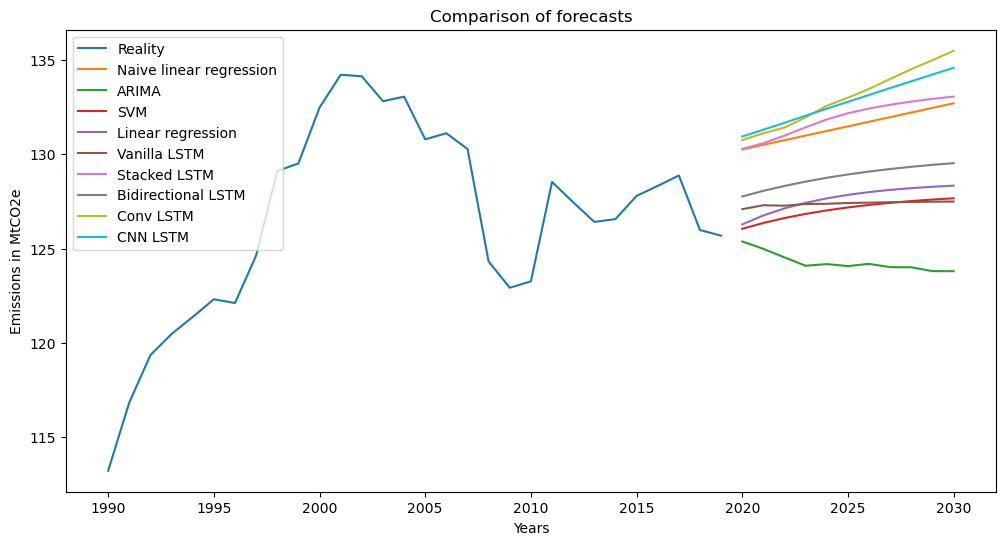

In [172]:
plot_all_forecasts(new_df)
plt.savefig("all_forecasts.png")

## Luxembourg Transportation All GHG

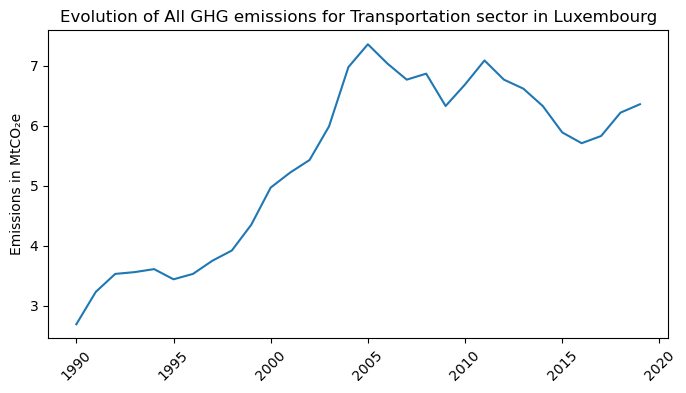

In [122]:
Lux_Wa_all = Selector(df=df,Country='Luxembourg',Sector= 'Transportation', Gas = 'All GHG')

MAE: 2.292
RMSE: 2.323
MAPE: 0.38
r2: -81.474


array([[7.4568046 ],
       [7.58932963],
       [7.72185465],
       [7.85437968],
       [7.98690471],
       [8.11942974],
       [8.25195476],
       [8.38447979],
       [8.51700482],
       [8.64952985],
       [8.78205488]])

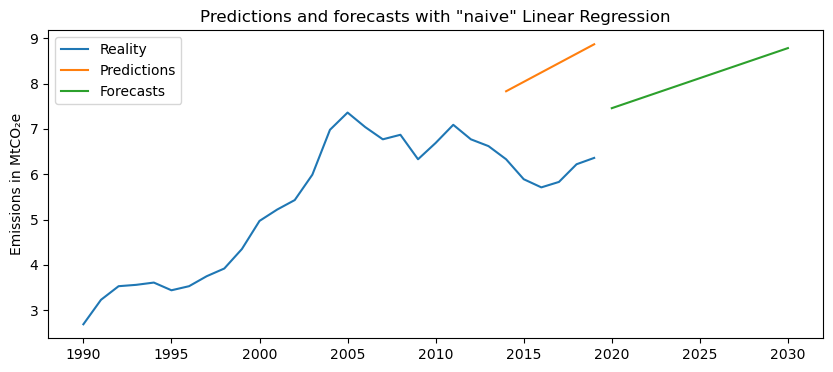

In [123]:
Lin_reg(Lux_Wa_all)

Best ARIMA(3, 0, 3) MAE=0.272
MAE: 0.272
RMSE: 0.307
MAPE: 0.046
r2: -0.444


2020-01-01    6.338726
2021-01-01    6.317649
2022-01-01    6.223716
2023-01-01    6.107394
2024-01-01    6.025584
2025-01-01    5.975544
2026-01-01    5.924638
2027-01-01    5.859731
2028-01-01    5.792715
2029-01-01    5.735864
2030-01-01    5.687911
Freq: AS-JAN, Name: mean, dtype: float64

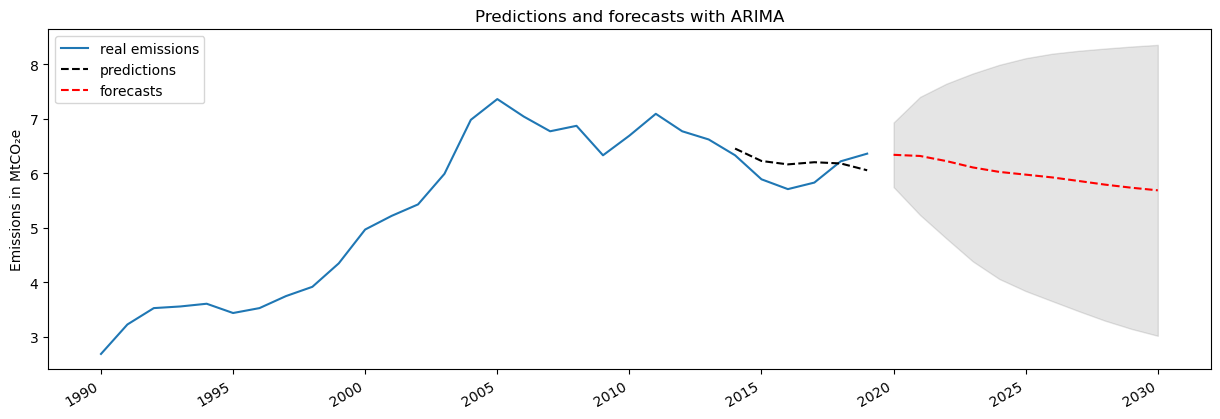

In [124]:
ARIMA(Lux_Wa_all)

Rolling timesteps:  2 

MAE: 0.238
RMSE: 0.296
MAPE: 0.04
r2: -0.339


[array([6.42275882]),
 array([6.47213881]),
 array([6.5151952]),
 array([6.55321151]),
 array([6.5868259]),
 array([6.61655291]),
 array([6.64284259]),
 array([6.66609245]),
 array([6.68665397]),
 array([6.70483801]),
 array([6.72091947])]

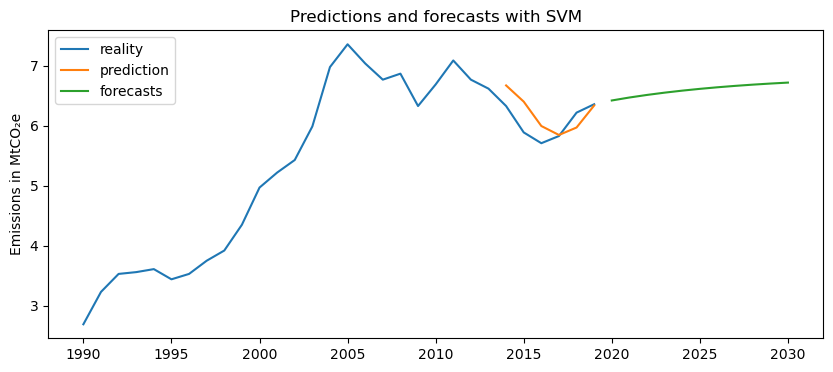

In [125]:
SVM(Lux_Wa_all, 2)